### Installing required packages 

In [1]:
!pip install scikit-uplift
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pickle
import numpy as np
import pandas as pd
import warnings
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import uplift_at_k, uplift_auc_score


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [3]:
warnings.filterwarnings('ignore')

In [4]:
plt.style.use('fivethirtyeight')

### Data loading



In [5]:
clients = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/x5_data/clients2.csv', parse_dates=['first_issue_date', 'first_redeem_date'])
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/x5_data/products.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/x5_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/x5_data/test.csv')

In [6]:
test_purchase = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/x5_data/test_purch.csv', parse_dates=['transaction_datetime']) 
train_purchase = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/x5_data/train_purch.csv',  parse_dates=['transaction_datetime']) 

In [7]:
train_purchase.shape , test_purchase.shape

((15998952, 13), (6883738, 13))

### EDA

1) Lets take a look at the Clients dataset

In [8]:
clients.head()

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [9]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          200039 non-null  object        
 1   client_id.1        0 non-null       float64       
 2   first_issue_date   200039 non-null  datetime64[ns]
 3   first_redeem_date  182493 non-null  datetime64[ns]
 4   age                200039 non-null  int64         
 5   gender             200039 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 9.2+ MB


In [10]:
clients['age'].describe()

count    200039.000000
mean         46.417329
std          49.532475
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1852.000000
Name: age, dtype: float64

Lets clean customers age

In [11]:
q_up = np.quantile(clients['age'], 0.99)
q_low = np.quantile(clients['age'], 0.01)

clients = clients.loc[(clients['age'] < q_up)&(clients['age'] > q_low), :]

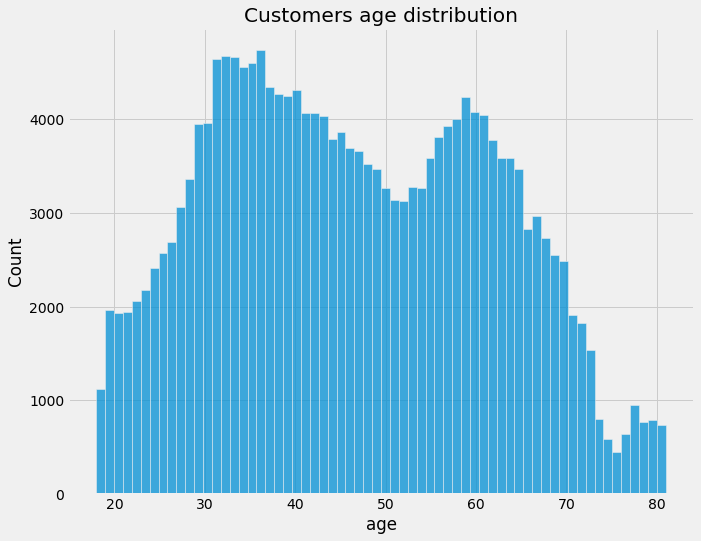

In [12]:
plt.figure(figsize=(10, 8))
sns.histplot(clients['age'], bins=len(clients['age'].unique()))
plt.title('Customers age distribution')
plt.show()

In [13]:
clients['gender'].value_counts()

U    90848
F    71920
M    32342
Name: gender, dtype: int64

In [14]:
clients.drop(columns=['client_id.1'], inplace=True)

Lets convert our date variables to int as days delta

In [15]:
clients['first_redeem_date'].fillna(clients['first_redeem_date'].median(), inplace=True)

clients.loc[:, 'first_redeem_date'] = (clients['first_redeem_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')
clients.loc[:, 'first_issue_date'] = (clients['first_issue_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')

clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,17383,17535,45,U
1,000036f903,17266,17279,72,F
3,0001f552b0,17347,17771,33,F
4,00020e7b18,17497,17541,73,U
6,00022fd34f,17515,17659,65,U


New feature - issue redeem delta shows us difference between first_issue_date and first_redeem_date 	 

In [16]:
clients['redeem_issue_delta'] = clients['first_redeem_date'] - clients['first_issue_date']

Merge train and clients datasets

In [17]:
train.head()

,client_id,treatment_flg,purchased
0,ad6561e2d8,1,1
1,7c1ccbf93f,1,1
2,b58fadcab6,1,1
3,e99e6fabb9,0,0
4,27fb6f8520,1,1


In [18]:
train_df = clients.merge(train,how = 'right', on = 'client_id')
test_df = clients.merge(test,how = 'right', on = 'client_id')
train_df.sample(10)

,client_id,first_issue_date,first_redeem_date,age,gender,redeem_issue_delta,treatment_flg,purchased
67599,6dbef6ff18,17957.0,17971.0,42.0,U,14.0,0,1
138016,c52eede3b1,17308.0,17684.0,59.0,F,376.0,1,1
9786,24e170fc55,17280.0,17341.0,45.0,U,61.0,0,1
25599,7c6bc8d737,17309.0,17624.0,72.0,F,315.0,1,1
4100,7f7f88c1d8,17432.0,17473.0,39.0,F,41.0,1,0
64355,80d9eb2115,17506.0,17763.0,65.0,F,257.0,1,0
79745,91a070c8e9,17379.0,17645.0,65.0,F,266.0,1,0
30380,b5ecc5bc94,17836.0,17903.0,63.0,U,67.0,1,0
135582,37635abef7,17353.0,17530.0,34.0,U,177.0,0,0
112749,fe2f6e7116,17384.0,17442.0,53.0,U,58.0,1,1


### Product Purchase merge

In [19]:
products.head(10)

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0
5,0008bf7786,e344ab2e71,749c619457,5e89a8adcc,d453d4e1e8,165.0,0d6f137fb6,88f2ca925a,0.750,0,1
6,0009170c33,c3d3a8e8c6,ad2b2e17d2,ca69ed9de2,8bbeabc581,212.0,NaN,6a48b9976d,0.400,0,0
7,000b76558e,c3d3a8e8c6,d283080a93,f976a3c5f9,38c655d9b4,48.0,ea9e0181eb,8f55c680fa,0.450,0,0
8,00117bd32b,c3d3a8e8c6,ad2b2e17d2,eda7b2976b,1e7082b4bb,177.0,c34d31ceec,7e01a40bc1,0.250,0,0
9,0011ab9d97,e344ab2e71,ed2ad1797c,b25baa9dd5,fe255b600a,116.0,fce7934ead,95ea122ece,0.005,0,0


Lets make a new feature that would tell us the percentage of the money the customer spends on alkohol:) 

In [20]:
train_purchase = train_purchase.merge(products[['product_id', 'is_alcohol']], on='product_id')
test_purchase = test_purchase.merge(products[['product_id', 'is_alcohol']], on='product_id')

### Train purchase aggregation

In [21]:
train_purchase.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,is_alcohol
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.00,54a4a11a29,9a80204f78,2.0,80.0,NaN,0
1,0027aac018,7be996a830,2018-12-08 14:46:14,1.0,0.0,-21.0,0.0,229.00,c72f410eb2,9a80204f78,1.0,36.0,40.0,0
2,00b19bc224,1001a6e6cb,2019-01-02 14:12:39,4.0,0.0,0.0,0.0,403.49,915aa2a84b,9a80204f78,1.0,40.0,NaN,0
3,00bb1bb4e8,c79c6f1815,2019-01-03 17:15:43,62.9,0.0,0.0,0.0,6893.00,5ac78637d2,9a80204f78,1.0,51.0,NaN,0
4,00e38f656d,c85b58be92,2019-03-15 14:37:08,32.5,0.0,-496.0,0.0,4480.00,2151d7db8f,9a80204f78,1.0,48.0,55.0,0


In [22]:
train_purchase[train_purchase['trn_sum_from_red'].isnull() == True].shape

(14943088, 14)

In [23]:
train_purchase.shape

(15998952, 14)

In [24]:
train_purchase.drop(columns=['trn_sum_from_red'], inplace=True)
test_purchase.drop(columns=['trn_sum_from_red'], inplace=True)


In [25]:
df_train_purch_spent = train_purchase\
    .groupby(['client_id','transaction_id'])[['express_points_spent', 'regular_points_spent', 
                                              'purchase_sum', 'is_alcohol']]\
    .last().groupby('client_id').agg({
        'express_points_spent': ['mean', 'sum'], 
        'regular_points_spent': ['mean', 'sum'],
        'purchase_sum': ['mean', 'sum'],
        'is_alcohol': ['mean']
    })


df_test_purch_spent = test_purchase\
    .groupby(['client_id','transaction_id'])[['express_points_spent', 'regular_points_spent', 
                                              'purchase_sum', 'is_alcohol']]\
    .last().groupby('client_id').agg({
        'express_points_spent': ['mean', 'sum'], 
        'regular_points_spent': ['mean', 'sum'],
        'purchase_sum': ['mean', 'sum'],
        'is_alcohol': ['mean']
    })

In [26]:
df_train_purch_spent.columns = ['express_points_spent_mean', 'express_points_spent_sum', 
                          'regular_points_spent_mean', 'regular_points_spent_sum',
                          'purchase_sum_mean', 'purchase_sum_sum', 'alcohol']


df_test_purch_spent.columns = ['express_points_spent_mean', 'express_points_spent_sum', 
                          'regular_points_spent_mean', 'regular_points_spent_sum',
                          'purchase_sum_mean', 'purchase_sum_sum', 'alcohol']

df_train_purch_spent.head(10)

,express_points_spent_mean,express_points_spent_sum,regular_points_spent_mean,regular_points_spent_sum,purchase_sum_mean,purchase_sum_sum,alcohol
client_id,,,,,,,
000012768d,0.000000,0.0,0.000000,0.0,700.750000,2803.00,0.000000
000036f903,0.000000,0.0,0.000000,0.0,306.406250,9805.00,0.000000
0001f552b0,0.000000,0.0,0.000000,0.0,410.345333,6155.18,0.000000
00020e7b18,-1.666667,-30.0,-32.888889,-592.0,1434.422778,25819.61,0.000000
000220a0a7,0.000000,0.0,0.000000,0.0,573.771333,8606.57,0.066667
00022fd34f,0.000000,0.0,-1.454545,-48.0,207.651818,6852.51,0.000000
0002ce2217,0.000000,0.0,0.000000,0.0,254.233077,3305.03,0.000000
00031cbbe6,0.000000,0.0,-2.068966,-60.0,319.535517,9266.53,0.000000
0004231e2a,0.000000,0.0,0.000000,0.0,497.937500,7967.00,0.062500


points recieved last month

In [27]:
points_last_month = train_purchase[
        train_purchase['transaction_datetime'] > '2019-02-18'
    ]\
    .groupby(['client_id', 'transaction_id'])['regular_points_received', 'express_points_received']\
    .last()\
    .groupby('client_id')\
    .sum()

points_last_month_test = test_purchase[
        test_purchase['transaction_datetime'] > '2019-02-18'
    ]\
    .groupby(['client_id', 'transaction_id'])['regular_points_received', 'express_points_received']\
    .last()\
    .groupby('client_id')\
    .sum()
    
points_last_month.head()

,regular_points_received,express_points_received
client_id,,
000012768d,10.0,0.0
000036f903,13.7,0.0
0001f552b0,47.0,0.0
00020e7b18,58.4,0.0
000220a0a7,26.1,0.0


In [28]:
points_last_month.describe()

,regular_points_received,express_points_received
count,140027.000000,140027.000000
mean,22.829296,0.021996
std,33.300777,0.937738
min,0.000000,0.000000
25%,4.800000,0.000000
50%,12.700000,0.000000
75%,28.000000,0.000000
max,1595.400000,40.000000


In [29]:
points_last_month.drop(columns=['express_points_received'], inplace=True)
points_last_month_test.drop(columns=['express_points_received'], inplace=True)
points_last_month.columns = ['regular_points_received_last_month']
points_last_month_test.columns = ['regular_points_received_last_month']


### Concat data

In [30]:
train_df = train_df.merge(df_train_purch_spent, on='client_id', how='left')
train_df = train_df.merge(points_last_month, on='client_id', how='left')

test_df = test_df.merge(df_test_purch_spent, on='client_id', how='left')
test_df = test_df.merge(points_last_month_test, on='client_id', how='left')


Lets count the average sum our customer spends per day. 

In [31]:
train_purchase.loc[:,'purchase_date'] =(train_purchase['transaction_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')
df_purchase_date = train_purchase.groupby('client_id').agg({
          'purchase_date': ['max', 'min']
      })
df_purchase_date['days_between_first_and_last_purch'] =  df_purchase_date['purchase_date']['max'] - df_purchase_date['purchase_date']['min']



test_purchase.loc[:,'purchase_date'] =(test_purchase['transaction_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')
df_purchase_date_test = test_purchase.groupby('client_id').agg({
          'purchase_date': ['max', 'min']
      })
df_purchase_date_test['days_between_first_and_last_purch'] =  df_purchase_date_test['purchase_date']['max'] - df_purchase_date_test['purchase_date']['min']





In [32]:
df_purchase_date.reset_index(inplace=True)
df_purchase_date_test.reset_index(inplace=True)


In [33]:
df_purchase_date.head()
df_purchase_date.columns=['client_id', 'purchase_date_max', 'purchase_date_min', 'days_between_first_and_last_purch']
df_purchase_date_test.columns=['client_id', 'purchase_date_max', 'purchase_date_min', 'days_between_first_and_last_purch']


In [34]:
train_df = train_df.merge(df_purchase_date[['client_id', 'days_between_first_and_last_purch']], on='client_id', how='left')

test_df = test_df.merge(df_purchase_date_test[['client_id', 'days_between_first_and_last_purch']], on='client_id', how='left')

train_df.head()

,client_id,first_issue_date,first_redeem_date,age,gender,redeem_issue_delta,treatment_flg,purchased,express_points_spent_mean,express_points_spent_sum,regular_points_spent_mean,regular_points_spent_sum,purchase_sum_mean,purchase_sum_sum,alcohol,regular_points_received_last_month,days_between_first_and_last_purch
0,ad6561e2d8,17503.0,17674.0,50.0,F,171.0,1,1,0.000000,0.0,-1.600000,-64.0,270.035250,10801.41,0.025,17.7,113
1,7c1ccbf93f,17480.0,17584.0,24.0,F,104.0,1,1,0.000000,0.0,0.000000,0.0,425.500000,851.00,0.000,9.4,14
2,b58fadcab6,17472.0,17789.0,36.0,U,317.0,1,1,0.000000,0.0,-9.363636,-309.0,429.447576,14171.77,0.000,18.3,114
3,e99e6fabb9,17667.0,17681.0,79.0,F,14.0,0,0,0.000000,0.0,0.000000,0.0,220.923077,2872.00,0.000,4.4,103
4,27fb6f8520,17364.0,17515.0,34.0,F,151.0,1,1,-1.666667,-50.0,-0.133333,-4.0,329.540333,9886.21,0.000,26.7,105


In [35]:
train_df['avg_spend_per_day'] = train_df['purchase_sum_sum'] / train_df['days_between_first_and_last_purch']

test_df['avg_spend_per_day'] = test_df['purchase_sum_sum'] / test_df['days_between_first_and_last_purch']

train_df.head()

,client_id,first_issue_date,first_redeem_date,age,gender,redeem_issue_delta,treatment_flg,purchased,express_points_spent_mean,express_points_spent_sum,regular_points_spent_mean,regular_points_spent_sum,purchase_sum_mean,purchase_sum_sum,alcohol,regular_points_received_last_month,days_between_first_and_last_purch,avg_spend_per_day
0,ad6561e2d8,17503.0,17674.0,50.0,F,171.0,1,1,0.000000,0.0,-1.600000,-64.0,270.035250,10801.41,0.025,17.7,113,95.587699
1,7c1ccbf93f,17480.0,17584.0,24.0,F,104.0,1,1,0.000000,0.0,0.000000,0.0,425.500000,851.00,0.000,9.4,14,60.785714
2,b58fadcab6,17472.0,17789.0,36.0,U,317.0,1,1,0.000000,0.0,-9.363636,-309.0,429.447576,14171.77,0.000,18.3,114,124.313772
3,e99e6fabb9,17667.0,17681.0,79.0,F,14.0,0,0,0.000000,0.0,0.000000,0.0,220.923077,2872.00,0.000,4.4,103,27.883495
4,27fb6f8520,17364.0,17515.0,34.0,F,151.0,1,1,-1.666667,-50.0,-0.133333,-4.0,329.540333,9886.21,0.000,26.7,105,94.154381


In [36]:
train_df.drop(columns=['days_between_first_and_last_purch'], inplace=True)
test_df.drop(columns=['days_between_first_and_last_purch'], inplace=True)


In [37]:
train_df.shape

(140027, 17)

In [38]:
train_df.to_csv('prepared_clients_data.csv', index=False)
test_df.to_csv('prepared_test_clients_data.csv', index=False)


In [39]:
del df_purchase_date, points_last_month, df_train_purch_spent
gc.collect()

0